<a href="https://colab.research.google.com/github/Minsoo1036/Algorithm-Study/blob/main/Counterfactual_TFT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

TFT 학습하기

In [4]:
!pip install pytorch_forecasting==1.0.0

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.1/46.1 kB 3.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 6.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.6/94.6 kB 6.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 380.1/380.1 kB 13.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 155.8/155.8 kB 8.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.2/233.2 kB 15.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.5/71.5 kB 5.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 5.2 MB/s eta 0:00:00


In [ ]:
!pip install cmaes

In [ ]:
!pip install optuna

In [ ]:
!pip install optuna-integration

In [2]:
!pip install lightning==2.4.0

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 811.0/811.0 kB 14.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 869.2/869.2 kB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 815.2/815.2 kB 34.7 MB/s eta 0:00:00


In [17]:
import warnings
import pickle
import copy
import os
import shutil

from sklearn import preprocessing
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import lightning.pytorch as pl
from lightning.pytorch.callbacks import EarlyStopping, LearningRateMonitor
from lightning.pytorch.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from datetime import datetime, date

#import seaborn as sns
import matplotlib.pyplot as plt

# import tensorflow as tf
#import tensorboard as tb
# tf.io.gfile = tb.compat.tensorflow_stub.io.gfile

#import seaborn as sns
import matplotlib.pyplot as plt

import warnings
import copy
warnings.filterwarnings(action='ignore')

In [7]:
total_df = pd.read_csv("/content/drive/MyDrive/jecheol_coal_counterfactual_df_update.csv")
total_df = total_df[['Date','Data','d1','d2']]
total_df['Date'][0]

'2006-01-01'

In [10]:
total_df['Date'] = total_df['Date'].map(lambda x : datetime.strptime(x, "%Y-%m-%d").date())

In [19]:
total_df = total_df.loc[total_df['Date']>=date(2010,1,1),]
total_df = total_df.loc[total_df['Date']<=date(2022,12,31),]

In [27]:
#total_df = total_df.reset_index()
total_df['date'] = total_df['date'].map(lambda x : datetime.combine(x, datetime.min.time()))

In [23]:
total_df = total_df.rename(columns={'Date':'date',
                                    'Data':'data'})
total_df = total_df.set_index('date')
total_df

,data,d1,d2
date,,,
2010-01-01,192.500,5691.0,88.193
2010-02-01,224.000,5213.0,90.285
2010-03-01,232.500,5845.0,89.946
2010-04-01,237.500,5831.0,90.014
2010-05-01,247.500,5860.0,93.832
...,...,...,...
2022-08-01,243.636,10200.0,117.591
2022-09-01,265.477,9900.0,121.600
2022-10-01,290.226,10500.0,123.526


In [30]:
earliest_time = total_df.index.min()

total_df_list = []

for label in total_df:

    if label == "data":

        ts = total_df[label]

        start_date = min(ts.fillna(method='ffill').dropna().index)
        end_date = max(ts.fillna(method='bfill').dropna().index)

        active_range = (ts.index >= start_date) & (ts.index <= end_date)
        ts = ts[active_range].fillna(0.)

        tmp = pd.DataFrame({'Y': ts})
        date = tmp.index

        tmp['hours_from_start'] = (date - earliest_time).seconds / 60 / 60 + (date - earliest_time).days * 24
        tmp['hours_from_start'] = tmp['hours_from_start'].astype('int')

        tmp['days_from_start'] = (date - earliest_time).days
        tmp['date'] = date
        tmp['consumer_id'] = label
        tmp['hour'] = date.hour
        tmp['day'] = date.day
        tmp['day_of_week'] = date.dayofweek
        tmp['month'] = date.month
        tmp['year'] = date.year

        #stack all time series vertically
        total_df_list.append(tmp)

    else:
        total_df_list.append(total_df[label])

time_df = pd.concat(total_df_list,axis=1).reset_index(drop=True)
time_df['hours_from_start'] = pd.Series(np.array([i for i in range(time_df.shape[0])]))

In [31]:
time_df

,Y,hours_from_start,days_from_start,date,consumer_id,hour,day,day_of_week,month,year,d1,d2
0,192.500,0,0,2010-01-01,data,0,1,4,1,2010,5691.0,88.193
1,224.000,1,31,2010-02-01,data,0,1,0,2,2010,5213.0,90.285
2,232.500,2,59,2010-03-01,data,0,1,0,3,2010,5845.0,89.946
3,237.500,3,90,2010-04-01,data,0,1,3,4,2010,5831.0,90.014
4,247.500,4,120,2010-05-01,data,0,1,5,5,2010,5860.0,93.832
...,...,...,...,...,...,...,...,...,...,...,...,...
151,243.636,151,4595,2022-08-01,data,0,1,0,8,2022,10200.0,117.591
152,265.477,152,4626,2022-09-01,data,0,1,3,9,2022,9900.0,121.600
153,290.226,153,4656,2022-10-01,data,0,1,5,10,2022,10500.0,123.526
154,282.148,154,4687,2022-11-01,data,0,1,1,11,2022,10400.0,119.901


In [34]:
#########################################################
seq_len = 12 #input_len
pred_len = 26 #output_len
val_rate = 0.2 #valid_rate

B = total_df.shape[0] - pred_len - seq_len + 1
A = int((1 - val_rate) * (B - pred_len + 1))

max_prediction_length = pred_len
min_prediction_length = pred_len
max_encoder_length = seq_len
training_cutoff = A + pred_len + seq_len - 1
##########################################################
training = TimeSeriesDataSet(
    time_df[lambda x: x.hours_from_start < training_cutoff],
    time_idx="hours_from_start",
    target='Y',
    group_ids=["consumer_id"],
    min_encoder_length=max_encoder_length,
    max_encoder_length=max_encoder_length,
    min_prediction_length=min_prediction_length,
    max_prediction_length=max_prediction_length,
    static_categoricals=["consumer_id"],
    time_varying_known_reals=['d1','d2'],
    time_varying_unknown_reals=['Y'],
    target_normalizer=GroupNormalizer(
        groups=["consumer_id"], transformation="softplus"
    ),  # we normalize by group

    #target_normalizer=MultiNormalizer(
    #    [EncoderNormalizer()]*len(fe_li) ##check this!!
    #   # groups=["consumer_id"]
    #),  # we normalize by group
    add_relative_time_idx=True,
    add_target_scales=False,
    add_encoder_length=False,
    allow_missing_timesteps=False,
)

validation = TimeSeriesDataSet.from_dataset(training, time_df[lambda x: x.hours_from_start >= training_cutoff - seq_len], predict=False, stop_randomization=True)
#test = TimeSeriesDataSet.from_dataset(training, test_df, predict=False, stop_randomization=True)

In [35]:
train_dataloader = training.to_dataloader(train=True, batch_size=32)
val_dataloader = validation.to_dataloader(train=False, batch_size=32)
#total_dataloader = total.to_dataloader(train=False, batch_size=32)

In [42]:
import optuna
from optuna.trial import TrialState
from optuna.integration import PyTorchLightningPruningCallback
from lightning.pytorch import seed_everything

In [48]:
n_trials = 2

def object(trial, training, validation):
    _params = {'gradient_clip_val': trial.suggest_float('gradient_clip_val', 0, 10),
               'hidden_size': trial.suggest_int('hidden_size', 10, 320, step=10),
               'hidden_continuous_size': trial.suggest_int('hidden_continuous_size', 10, 320, step=10),
               'dropout': trial.suggest_float("dropout", 0, 0.5),
               'attention_head_size': trial.suggest_int('attention_head_size', 1, 4),
               #'rnn_layers': trial.suggest_int('rnn_layers', 1, 4),
               'learning_rate': trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True), #trial.suggest_float("learning_rate", 1e-5, 1e-3, log=True)
               #'rank': trial.suggest_int('rank', 1, 3),
               'batch_size': 2 ** trial.suggest_int('batch_size', 1, 8), #trial.suggest_int('batch_size', 8, 256, step=8)
               }

    #dm.batch_size = _params['batch_size']

    hpo_path = './HPO/'
    # logger = CSVLogger(hpo_path)
    logger = TensorBoardLogger(hpo_path)
    earlystopping = EarlyStopping(monitor="val_loss", patience=7, mode="min")

    _epochs = 10

    trainer = pl.Trainer(max_epochs=_epochs,
                    #devices=gpu,
                    gradient_clip_val=_params['gradient_clip_val'],
                    callbacks=[PyTorchLightningPruningCallback(trial, monitor='val_loss'), earlystopping],
                    logger=logger,
                    enable_checkpointing=False,
                    enable_model_summary=False,
                    enable_progress_bar=False,
                    )

    seed_everything(42, workers=True)
    model = TemporalFusionTransformer.from_dataset(
        training,
        log_interval=10,
#         loss = MultiLoss([MultivariateNormalDistributionLoss(rank=_params['rank']) for _ in range(len(DVAR_config['fe_li']))]), # check this!!
        learning_rate=_params['learning_rate'],
        hidden_size=_params['hidden_size'],
        attention_head_size=_params['attention_head_size'],
        hidden_continuous_size=_params['hidden_continuous_size'],
        output_size=7,
        loss=QuantileLoss(),
        #rnn_layers=_params['rnn_layers'],
        dropout = _params['dropout'],
        reduce_on_plateau_patience=4,
    )
    train_dataloader = training.to_dataloader(train=True, batch_size=params['batch_size'])
    val_dataloader = validation.to_dataloader(train=False, batch_size=params['batch_size'])
    trainer.fit(model, train_dataloader, val_dataloader)

    return trainer.callback_metrics['val_loss'].item()

# -----------------------------------------------------------------------------------

# !!!!!!!!!!!!!!!!!!!Need cmaes packapge!!!!!!!!!!!!!!!!!!!
sampler = optuna.samplers.CmaEsSampler(
    restart_strategy="ipop",
    inc_popsize=2,
    seed=42
)
# sampler = optuna.samplers.TPESampler(seed=42)

pruner = optuna.pruners.HyperbandPruner(min_resource=9)
study = optuna.create_study(sampler=sampler, direction='minimize', pruner=pruner)
study.optimize(lambda x: object(x,training, validation), n_trials=n_trials)

pruned_trials = study.get_trials(deepcopy=False, states=[TrialState.PRUNED])
complete_trials = study.get_trials(deepcopy=False, states=[TrialState.COMPLETE])

[I 2024-10-10 01:41:54,512] A new study created in memory with name: no-name-f70ec064-3180-43a8-9633-dfdccc63b958
INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.
[I 2024-10-10 01:43:18,561] Trial 0 finished with value: 63.78971862792969 and parameters: {'gradient_clip_val': 3.745401188473625, 'hidden_size': 310, 'hidden_continuous_size': 240, 'dropout': 0.2993292420985183, 'attention_head_size': 1, 'learning_rate': 2.0511104188433963e-05, 'batch_size': 1}. 

In [49]:
print("Study statistics: ")
print("Number of pruned trials: ", len(pruned_trials))
print("Number of complete trials: ", len(complete_trials))
print("Number of finished trials: ", (len(study.trials)))

print("Best trial:")
trial = study.best_trial

print("  Value: ", trial.value)
print("=========================================")

params = trial.params
print("params = ", params)

Study statistics: 
Number of pruned trials:  0
Number of complete trials:  2
Number of finished trials:  2
Best trial:
  Value:  63.78971862792969
params =  {'gradient_clip_val': 3.745401188473625, 'hidden_size': 310, 'hidden_continuous_size': 240, 'dropout': 0.2993292420985183, 'attention_head_size': 1, 'learning_rate': 2.0511104188433963e-05, 'batch_size': 1}


In [50]:
params

{'gradient_clip_val': 3.745401188473625,
 'hidden_size': 310,
 'hidden_continuous_size': 240,
 'dropout': 0.2993292420985183,
 'attention_head_size': 1,
 'learning_rate': 2.0511104188433963e-05,
 'batch_size': 1}

In [38]:
import optuna

In [51]:
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-4, patience=5, verbose=True, mode="min")
lr_logger = LearningRateMonitor()
logger = TensorBoardLogger("lightning_logs")

#candi 1 (optuna 3)
#opt_dict = {'gradient_clip_val': 0.21975398647840771, 'hidden_size': 71, 'dropout': 0.22236759230569286, 'hidden_continuous_size': 71, 'attention_head_size': 1, 'learning_rate': 0.0021007460290475475}

#candi 2 (optuna 30)
#opt_dict ={'gradient_clip_val': 0.5651746723889943, 'hidden_size': 72, 'dropout': 0.13494454956109558, 'hidden_continuous_size': 43, 'attention_head_size': 1, 'learning_rate': 0.012790101004929715}
trainer = pl.Trainer(
    #accelerator='gpu', # devices=[0],
    max_epochs=10,
    enable_model_summary=True,
    gradient_clip_val=params['gradient_clip_val'],
    callbacks=[lr_logger, early_stop_callback],
    logger=logger,
    log_every_n_steps = 1
)





tft = TemporalFusionTransformer.from_dataset(
    training,
    learning_rate=params['learning_rate'],
    hidden_size=params['hidden_size'],
    attention_head_size=params['attention_head_size'],
    dropout=params['dropout'],
    hidden_continuous_size=params['hidden_continuous_size'],
    output_size=7,  # there are 7 quantiles by default: [0.02, 0.1, 0.25, 0.5, 0.75, 0.9, 0.98]
    loss=QuantileLoss(),
    log_interval=10,
    reduce_on_plateau_patience=4,
)

train_dataloader = training.to_dataloader(train=True, batch_size=2**params['batch_size'])
val_dataloader = validation.to_dataloader(train=False, batch_size=2**params['batch_size'])

import os
trainer.fit(
    tft,
    train_dataloaders=train_dataloader,
    val_dataloaders=val_dataloader,
)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO: 
   | Name                               | Type                            | Params | Mode 
------------------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0      | train
1  | logging_metrics                    | ModuleList                      | 0      | train
2  | input_embeddings                   | MultiEmbedding                  | 1      | train
3  | prescalers                         | ModuleDict                      | 1.9 K  | train
4  | static_variable_selection          | VariableSelectionNetwork      

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved. New best score: 108.792
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved. New best score: 108.792


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.136 >= min_delta = 0.0001. New best score: 96.657
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 12.136 >= min_delta = 0.0001. New best score: 96.657


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 12.394 >= min_delta = 0.0001. New best score: 84.263
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 12.394 >= min_delta = 0.0001. New best score: 84.263


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 9.996 >= min_delta = 0.0001. New best score: 74.267
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 9.996 >= min_delta = 0.0001. New best score: 74.267


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 7.208 >= min_delta = 0.0001. New best score: 67.059
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 7.208 >= min_delta = 0.0001. New best score: 67.059


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 2.280 >= min_delta = 0.0001. New best score: 64.779
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 2.280 >= min_delta = 0.0001. New best score: 64.779


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.679 >= min_delta = 0.0001. New best score: 64.100
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.679 >= min_delta = 0.0001. New best score: 64.100


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.157 >= min_delta = 0.0001. New best score: 63.943
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.157 >= min_delta = 0.0001. New best score: 63.943


Validation: |          | 0/? [00:00<?, ?it/s]

INFO: Metric val_loss improved by 0.254 >= min_delta = 0.0001. New best score: 63.689
INFO:lightning.pytorch.callbacks.early_stopping:Metric val_loss improved by 0.254 >= min_delta = 0.0001. New best score: 63.689
INFO: `Trainer.fit` stopped: `max_epochs=10` reached.
INFO:lightning.pytorch.utilities.rank_zero:`Trainer.fit` stopped: `max_epochs=10` reached.


In [54]:
trainer.checkpoint_callback.best_model_path

'lightning_logs/lightning_logs/version_0/checkpoints/epoch=9-step=370.ckpt'

In [62]:
pred = np.array(tft.predict(time_df.head(12+26)))

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


In [67]:
pred = pred.reshape(-1,1)

In [64]:
real = np.array(time_df.head(12+26).tail(26)['Y'])
real

array([328.35 , 328.   , 327.63 , 326.375, 310.025, 304.773, 305.929,
       295.976, 272.341, 250.2  , 234.833, 227.31 , 219.447, 214.595,
       209.682, 216.1  , 222.409, 224.333, 206.114, 168.238, 145.75 ,
       146.568, 160.19 , 159.325, 165.841, 171.868])

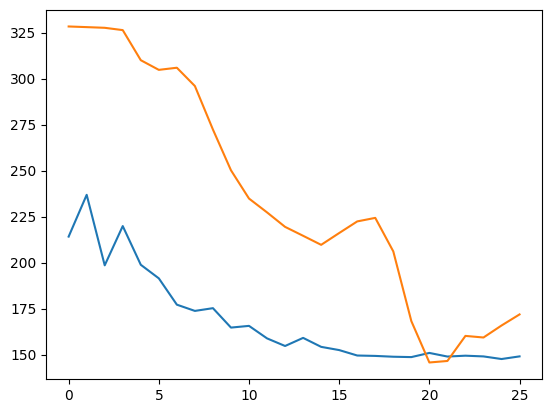

In [68]:
plt.plot(pred)
plt.plot(real)